In [ ]:
# Notebook 2: U-Net++ Model with Enhanced Evaluation Metrics for Lesion Segmentation

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.mixed_precision import Policy
from google.colab import drive
import cv2
import tensorflow.keras.backend as K

# Enable Mixed Precision
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
base_dir = '/content/drive/MyDrive/health_care_project/extracted_files'
train_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_Data')
train_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Training_GroundTruth')
test_images_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_Data')
test_masks_dir = os.path.join(base_dir, 'ISBI2016_ISIC_Part1_Test_GroundTruth')

# Load images and masks
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
    return np.array(images)

train_images = load_images_from_folder(train_images_dir)
train_masks = load_images_from_folder(train_masks_dir)
test_images = load_images_from_folder(test_images_dir)
test_masks = load_images_from_folder(test_masks_dir)

# Preprocess data
train_images = train_images / 255.0
train_masks = train_masks / 255.0
train_masks = np.expand_dims(train_masks[:, :, :, 0], axis=3)  # single-channel masks
test_images = test_images / 255.0
test_masks = test_masks / 255.0
test_masks = np.expand_dims(test_masks[:, :, :, 0], axis=3)  # single-channel masks

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)





Mounted at /content/drive


In [ ]:
import tensorflow.keras.backend as K


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.cast(K.flatten(y_true), dtype='float32')
    y_pred_f = K.cast(K.flatten(y_pred), dtype='float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )
# Define U-Net++ model (Simplified version)
def unet_plus_plus(input_size=(128, 128, 3), num_classes=1):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c4)

    # Decoder with U-Net++ style nested skip connections
    # For simplicity, only one level of nested connections is implemented
    u5 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, (1,1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.6469 - dice_coef: 0.3187 - loss: 0.6233 - mean_io_u: 0.3682 - val_accuracy: 0.7403 - val_dice_coef: 0.3263 - val_loss: 0.5130 - val_mean_io_u: 0.3713
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7341 - dice_coef: 0.3644 - loss: 0.4915 - mean_io_u: 0.3612 - val_accuracy: 0.8638 - val_dice_coef: 0.4843 - val_loss: 0.3925 - val_mean_io_u: 0.3713
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.8607 - dice_coef: 0.5566 - loss: 0.3829 - mean_io_u: 0.3617 - val_accuracy: 0.8668 - val_dice_coef: 0.6185 - val_loss: 0.3650 - val_mean_io_u: 0.3713
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.8804 - dice_coef: 0.6427 - loss: 0.3205 - mean_io_u: 0.3656 - val_accuracy: 0.9013 - val_dice_coef: 0.6681 - val_loss: 0.2685 - val_mean_io_u: 0.3713
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8925 - dice_coef: 0.6986 - loss: 0.2878 - mean_io_u: 0.3618 - val_ac

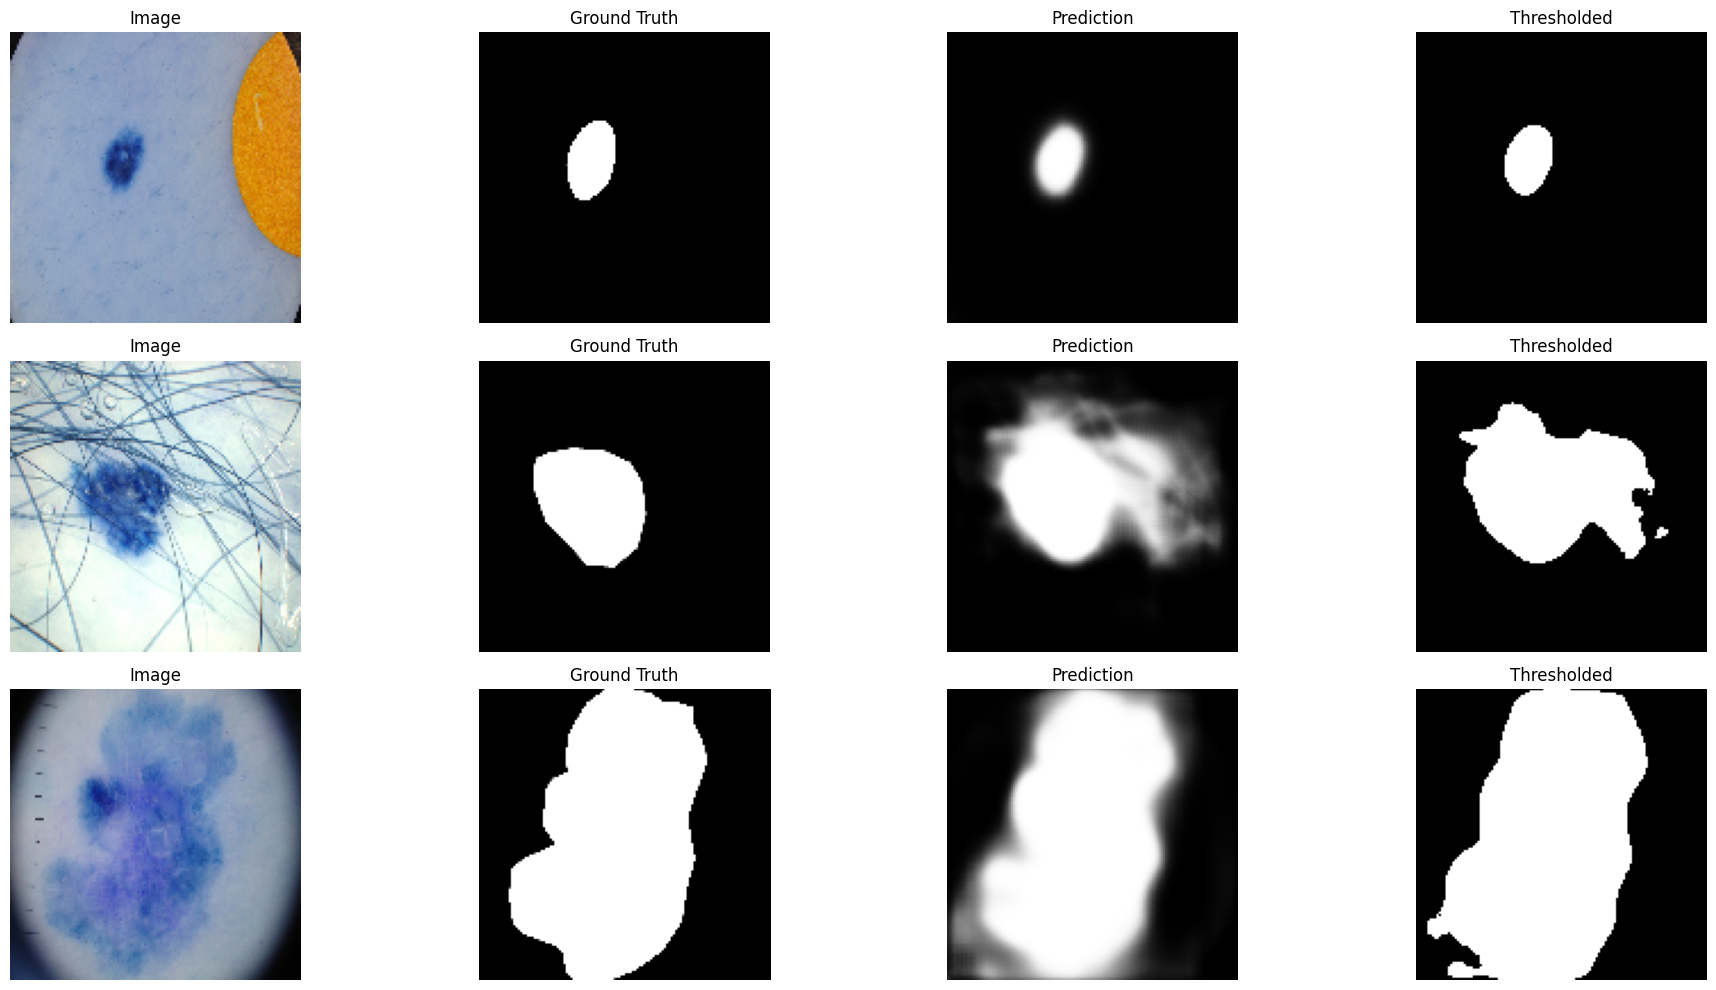

In [ ]:
model = unet_plus_plus()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[MeanIoU(num_classes=2), dice_coef, 'accuracy']
)

# Training the model
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/health_care_project/unet_plus_plus_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model
test_loss, test_miou, test_dice, test_accuracy = model.evaluate(test_images, test_masks)
print(f'Test Loss: {test_loss}')
print(f'Test Mean IoU: {test_miou}')
print(f'Test Dice Coefficient: {test_dice}')
print(f'Test Accuracy: {test_accuracy}')

# Visualize predictions
def display_predictions(images, masks, model, num_images=3):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        idx = np.random.randint(0, images.shape[0])
        image = images[idx]
        mask = masks[idx]
        prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
        prediction_thresholded = (prediction > 0.5).astype(np.float32)

        plt.subplot(num_images, 4, i*4 + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_images, 4, i*4 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_images, 4, i*4 + 3)
        plt.imshow(prediction, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(num_images, 4, i*4 + 4)
        plt.imshow(prediction_thresholded, cmap='gray')
        plt.title('Thresholded')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(test_images, test_masks, model)